***Identify a deafault client (CREDIT SCORING)***

<img src = 'https://www.nationalvanguard.org/wp-content/uploads/2016/03/debt-slave.jpg' width='400px' >

<a id="sec1"></a>
# [Description](#sec1)

Enter text here

<a id="sec1.1"></a>
## [Features Defination](sec1.1)

client_id -  client ID

education - the level of education

sex - borrowe's gender

age - borrowers age

car - has(has no) car

car_type - flag of car type

decline_app_cnt - number of rejected past applications

good_work - good job flag

bki_request_cnt - number of requests to Credit bureau

home_address - home address categorizer 

work_address - work address categorizer 

income - borrower's income

foreign_passport - has (has no) traveling passport

sna - Relationships of borrower with the bank's clients

first_time - how old the information about the borrower was

score_bki - score based on data from Credit bureau

region_rating - region rating

app_date - application date

default - has (has no) default

<a id="sec2"></a>
# [INDEX](#sec2)
1. [Description](#sec1)
    * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [IMPORT LIBRARRIES](#sec3)
4. [Functions and Classes](#sec4)
5. [Load and Chek the Dataset](#sec5)
    * [Data Types](#sec5.1)
    * [Pandas Profiling](#sec5.2)
6. [EDA](#sec6)
    * [Bolean Feature analysis](#sec6.1)
    * [Categorical Feature analysis](#sec6.2)
    * [Numerical Feature analysis](#sec6.3)
    * [Date_Time analysis](#sec6.4)
    * [Draw a conclusion](#sec6.5)
7. [Naive Model](#sec7)
8. [Feature Engineering](#sec8)

5. [Visualization](#sec5)
    * [5.1 Correclation](#sec5.1)
    * [Significance of continuous variables ](#sec5.2)
6. [Categorical Vars](#sec6)

<a id="sec3"></a>
# [IMPORT LIBRARRIES](sec3)

In [200]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier 
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score,plot_roc_curve
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
# from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from jupyterthemes import jtplot

warnings.filterwarnings("ignore")
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
%matplotlib inline

In [ ]:
# fix the version of the packages so that the experiments are reproducible:
#!pip freeze > requirements.txt

In [2]:
# Lock a RANDOM SEED to keep experiments reproducible.
RANDOM_SEED = 42

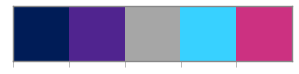

In [3]:
colors = ['#001c57', '#50248f', '#a6a6a6', '#38d1ff','#cc3181']
sns.palplot(sns.color_palette(colors))

<a id="sec4"></a>
# [Functions and Classes](#sec4)

In [4]:
def pandas_report(data):
    ''' Function is called for generating of dataset profile-report'''

    profile = data.profile_report(
        title='Credit Scoring',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True,
                        'warn_high_correlations': True,
                        'threshold': 0.9},
            'spearman': {'calculate': True,
                        'warn_high_correlations': True,
                        'threshold': 0.9},
            'kendall': {'calculate': False},
            'phi_k': {'calculate': False},
            'cramers': {'calculate': False}        
        },
        
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat' : {'n_obs':10}
        }
    )
    
    return profile

In [5]:
def get_boxplot(data,col1,col2,hue=None):
    '''Function is called to plot boxplots'''
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.boxplot(x=col1, y=col2, hue=hue,data=data, palette=colors)
    plt.xticks(rotation=45)
#     ax.set_title('Boxplot for ' + col1 + 'and' + col2,fontsize=14)
    ax.set_title(f'Boxplot for {col1} and {col2}',fontsize=14)
    plt.show()

In [6]:
class Preprocessing:
    def __init__(self,data):
        self.data = data
#         self.column = column
    
    def label_encoder(self,column):
        le = LabelEncoder()
        self.data[column] = le.fit_transform(self.data[column])
        
    def hot_enc(self,column):
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
        aux_df = pd.DataFrame(ohe.fit_transform(self.data[[column]]))
        aux_df.columns = ohe.get_feature_names(['hot_encode'])
        self.data = self.data.drop(col,axis=1)
        self.data = pd.concat([self.data, aux_df], axis=1)
        return self.data       

In [7]:
# def pre_processing(column,data):
#     '''Function is called to encode feature'''
#     le = LabelEncoder()
#     data[column] = le.fit_transform(data[column])

In [8]:
def missing_vars(data,col = 'education', random_proba=True):
    # With using probability and random choise

    if random_proba:
        col_name = data[col].value_counts(
        ).index.to_list()  # get list of values
        col_distr = data[col].value_counts(
            normalize=True).values  # get l;ist of probs
        missing = data[col].isnull()  # flag of missing val
        # substitute values from the list of names in accordance with the probability of meeting the name 
        data.loc[missing, [col]] = np.random.choice(
            col_name, size=len(data[missing]), p=col_distr)
    
    # Using  most common in  column
    data[col] = data[col].fillna(
    data[col].value_counts().index[0])

In [9]:
def corr_matrix(data, det=True, pltx = 10, plty=10):
    X = data.corr()
    if det:
        
        evals,evec = np.linalg.eig(X)
        ev_product = np.prod(evals)
    
        print(f'Rank of Matrix: {np.linalg.matrix_rank(X)}')
        print(f'Determinat of matrix: {np.round(ev_product,4)}')
        print(f'Shape of matrix: {np.shape(X)}')
    
    plt.figure(figsize=(pltx,plty))
    sns.heatmap(X,vmin=0,vmax=.9,annot=True,square=True)
    plt.show()

In [10]:
def get_num_info(col,title = None):
    '''Function is called to plot feture distribution'''
    
    title = title if title is not None else f"Distribution for '{col}"
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),)
    fig = sm.qqplot(col, fit=True,line='45',ax=ax1)
    fig.suptitle(title,fontsize=20)
    
    sns.distplot(col.values, bins=20, color=colors[1],ax=ax2)
    
#     sns.boxplot(col,width=.2,color=colors[3])
    sns.violinplot(col.values,color=colors[3],bw=.3,cut=1,linewidth=4)
    
    
    ax1.set_title('QQ-plot')
    ax2.set_title('Distribution')
    ax3.set_title('Violinplot')
    
    plt.show()

In [11]:
def detect_outliers(data):
    '''Function is called to detect outliers'''
    q1,q3 = np.percentile(sorted(data),[25,75])
    
    IQR = q3 - q1
    
    l_b = q1 - (1.5 * IQR)
    u_b = q3 + (1.5 * IQR)
    outl_count = len(data[data < l_b]) + len(data[data > u_b])
    
    print(f'Lower Bound: {round(l_b,3)}, Upper Bound {round(u_b,3)}, Outliers Count: {outl_count}')

In [12]:
'''Функция, возвращающая порядковый день в году'''
def get_days_count(x):  
    day = ((x.month-1) * 30)+x.day
    return day
'''Функция, возвращающая количество дней между датой заявки и сегодняшним числом'''
def get_days_beetwen(x):
    curr_date = datetime.today()
    count = (curr_date-x).days
    return count
    
'''Функция, возвращающая флаг подачи заявки в выходной день'''
def if_weekend(x):
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0

def month(x):
    month = x.month
    return month

In [13]:
def make_confusion_matrix(cf, group_names=['TN', 'FP', 'FN', 'TP'],
                           categories='auto',
                           sum_stats=True,
                           count=True,
                           cbar=True,
                           percent=True,
                           cmap='Blues'):
    '''Function is called for making a confusion matrix
    args
    ------
    cf - confusion matrix
    group_names - Names for each group
    categories -  categories to be displayed on the x,y axis. Default is 'auto'
    sum_stats -   shows Accuracies. Deafult is TRUE
    c_bar -       If True, show the color bar. The cbar values are based off the values in the confusion matrix. 
                  Default is True
    percent -     to be displayed on the x,y axis. Default is True
    '''
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]


    group_labels = ["{}\n".format(value) for value in group_names]

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(
            value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(
        group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # Metrics
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))
        ball_accuracy = .5*(cf[1, 1] / sum(cf[1, :]) +
                            cf[0, 0] / sum(cf[0, :]))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # pr = how many real true
            precision = cf[1, 1] / sum(cf[:, 1])
            # How many positives from all positives
            recall = cf[1, 1] / sum(cf[1, :])
            # F1 score
            f1_score = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nBallancedAcc={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, ball_accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    plt.rcParams.get('figure.figsize')
    plt.figure(figsize=(5, 5))
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label' + stats_text)

In [14]:
def make_roc_auc(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2);
    plt.show()

<a id="sec4"></a>
# [Load and Chek the Dataset](#sec4)

In [15]:
# df_train = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\train.csv')
df_train = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\train.csv')

# df_test = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\test.csv')

df_test = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\test.csv')


# submission = pd.read_csv(
#     r'C:\Users\wangshu202040\The A-Team\sf-dst-scoring\sample_submission.csv')

submission = pd.read_csv(
    r'C:\Users\Paul\The_A-team\sf-dst-scoring\sample_submission.csv')

For the processing and EDA, let's concatenate two dataframes into a one.

In [16]:
# For the correct processing of features, combine train and test sets into a one dataset

df_train['sample'] = 1  # train
df_test['sample'] = 0  # test
# as we have to predict rating, in test set we just fill it with 0
#df_test['default'] = 0

df1 = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # combine sets

In [17]:
display(df.sample(3))
df.info()

NameError: name 'df' is not defined

<a id="sec5.1"></a>
## [Data Types](#sec5.1)

In [15]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').agg('count').reset_index()

NameError: name 'df' is not defined

In [ ]:
for i, j in enumerate(df.columns):
    print(j, type(df.loc[1][i]))

<a id="sec5.2"></a>
## [Pandas Profiling](#sec5.2)

In [ ]:
#data_profile = pandas_report(df_train)
#data_profile.to_file('result.html') # Check your folder

 - Dataset has 19 features (excluding feature ''Sample)
 
 - Total Number Of observations is 110 148
 
 - Missing values is about 0.04%
 
 - There is no duplicates
 
 
 - ***Client_id*** has 100% unique values 
 
 - ***app_date*** has only 120 distinct values (0.1%). Most of presented dates concentrated in MARCH2014, APRIL2014, FEB2014. We need to process this column in further
 
 - ***education*** Consists 5 distinct categories: 
     
 - - SCH (52%) - School;
 
 - - GRD (31%) - Graduated (Master degree);
 
 - - UGR (13%) - UnderGraduated (Bachelor degree);
 
 - - PGR (1.7%) - PostGraduated;
 
 - - ACD (0.3%) - Academic Degree;
 
 - - Missing (0.4%)
 
 
 We will see how it is impact on a result and probably generate new feature 'Has/Has No Hi-degree education'
 
 - ***sex*** Consists 2 distinct categories:
 - - Female (56%);
 
 - - Male (44%);
 
 
 - ***age*** Is a real Number variable. The distribution is a left-shifted.
 
 -- Minimum	21
 
 -- median	37
 
 -- Mean	39.2
 
 -- Maximum	72
 
 -- Interquartile range (IQR)	18
 
 - ***car*** Is a boolean variable. 67% of borrowers has no car.
 
 
 - ***car_type*** Is a boolean variable which shows whethere the borrower has domestic or foreign car. 81% of borrowers has domesatic.
 
 
 - ***decline_app_cnt*** Is a real number value. Distribution is shifted to the left. Most of values (83%) has zeros which is reasonable. Overwhelimng majority of the observations are located between 0 and 6. We might convert this feature to categorical or ordinal.
 
 -- Maximum	33


 - ***good_work*** Most of borrowers have not good job (83%). It is interesting it here any relations between good job and education? We also want to know, does someone has poor education, bad job and foreign car (Just for fun)
 
 
 - ***score_bki*** Is a real number variable. It consists 93% distinct values. We may note, that it has approximately normal distribution and also consists negative values. Most likely it is already scaled by Standard Scaler.
 
 
 - ***bki_request_cnt*** Is a real number variable with max.requests - 53, min - 0 and median - 1. Most of values scattered from 0 to 8 attempts.
 
 - ***region_rating*** It has kind of grade from 20 up to 80. We would say it is more similar with categoreical feature. Most common rating is 50 (37%)
 
 - ***home_address, work_address*** Is a categorical data with 3 categories.
 
 - ***income*** Biased distribution with large scatter of values - from 1000 to 1 000 000. Here we can try to convert it in a categorical value, assigning the income values to the categories - low income, medium, above medium, etc. 
 
 - ***sna / first_time***  Are categorical features and have 4 categories.  Nothing intersting seems.
 
 - ***foreign_passport*** Is a boolean feature. 67% of borrowers have foreign passport
 
 
 - ***default*** is our target which we have to predict. It is a boolean var, with overwhelming majority of 'good clients'. We may note that this feature is unballanced and the ratio is 1:6.8 which is unballanced a bit. In the feature engenireeng we will try apply under and oversampling and will se results.

<a id="sec6"></a>
# [ANALYZE DATA](#sec6)

<img src = 'https://media.makeameme.org/created/analyze-the-data.jpg' width = '400px' >

In [ ]:
bool_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = [
    'education', 'region_rating', 'home_address', 'work_address', 'sna',
    'first_time'
]
num_cols = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

<a id="sec6.1"></a>
## [Boolean feature analysis](#sec6.1)

In [ ]:
plt.figure(figsize=[20, 20])
i = 1

# y, hue = 'Proportion', 'default'

for k in bool_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=df_train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette=[colors[3], colors[4]])
    plt.title('Binary Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()


By looking at plots, we may note that female borrowers tend to be default slightly more than males. 

Borrowers, who has a car could be considered as more reliable.Borrowers who do not have a car tend not to repay their loans twice as often as those who have a car.

Those borrowers who have a car and that car is made abroad,tend to be more reliable. However, if we want to see the distribution more clear, we need to create a new category in this col: Has a domestic car, has a foreign car, has no car.

People, who have good jobs and foreign passport tend to return loans more often than those, who have bad jobs.

Let's check the how our features statistically significant?

To do so, let's encode it to binary entities.

In [ ]:
encoder = Preprocessing(df_train)

In [ ]:
for col in bool_cols:
    encoder.label_encoder(col)

df_train.sample(3)

In [ ]:
imp_bol = pd.Series(mutual_info_classif(df_train[bool_cols], df_train['default'], 
                                     discrete_features=True), index=[bool_cols])
imp_bol.sort_values(inplace=True)
imp_bol.plot(kind='barh')

Well, most significant feature to client's default is ***foreign_passport*** and ***car_type***

Now, get a look into a correlation matrix

In [ ]:
corr_matrix(df_train[bool_cols])

We have strong correlation between car and car_type. This can be explained by the fact that the column ***car*** indicates the presence of a car, and in the column ***car_type*** the presence of a foreign car, however, the absence of a car or whether the car is domestic is not indicated in ***car_type***. In feature engineering section we will combine information from these to columns into a one. It allows us reduce matrix of features without loosing information.

In addition, car is correlated with sex a bit.

<a id="sec6.2"></a>
## [Categorical Feature analysis](#sec6.2)

Before we do, let's convert categories into a numbers

In [ ]:
missing_vars(df_train)

In [ ]:
plt.figure(figsize=[20, 20])
i = 1

# y, hue = 'Proportion', 'default'

for k in cat_cols:
    plt.subplot(4, 3, i)
    sns.barplot(x=k, y='proportion', hue='default',  data=df_train[[
                k, 'default']].value_counts(normalize=True).rename('proportion').reset_index(),palette=[colors[3], colors[4]])
    plt.title('Binary Feature Name\n' + k, fontsize=15)
    i += 1
plt.tight_layout()
plt.show()

Here we can see that people with low-grade education fail to return loans more often than people with high-grade education.

The feature ***region_rating*** gives an interesting insight. The lower rating of the region, the higher share of overdue loan payments.

Home address and work addres are almost the same. We just can see that share of failed borrowers different from each address. Perhaps it has some insights. We will check later.

The category 4 in ***sna*** feature has a higher ratio of failed borrowers. And it falls by reducing the category from 4 to 1.

First time columns also shows us the fall of share of failed borrowers.

Let's see, how the region rating depends on education

In [ ]:
get_boxplot(df_train,'education','region_rating')

People with high level of education prefer to live in a region with higher level

OK, and now let's see the distribution of the failed borrowers by region_rating

In [ ]:
get_boxplot(df_train,'default','region_rating')

We may see that default clients lives in mid level regions. The higher rating of the city, the lower the chance of default. It must be a good insight for a model

It's interesting, can we observe some relationships between education level and the connection of borrowers with another clients of a bank?
Let's see that. 

In [ ]:
get_boxplot(df_train,'education','sna',hue='default')

Связи с клиентами банка имеют люди, в основном с низким уровнем образования. Возможно это можно объяснить тем, что люди с низким образованием работают в больших коллективах (заводы, фабрики) и обмен информации лучше или людям с высоким образованием не нужны поручители. Дефолтных клиентов также больше именно в этих категориях.

People, mostly with a low level of education, have connections with the bank's clients. Perhaps this can be explained by the fact that people with low education work in large teams (factories, factories) and the exchange of information is better, or people with higher education do not need guarantors. There are also more default clients in these categories. 

Check the significance and correlation

In [ ]:
for col in cat_cols:
    encoder.label_encoder(col)

In [ ]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
corr_matrix(df_train[cat_cols])

We have quite stong correlation between sna and first_time. Also, these two columns has best significance to a target variable. We may guess, that these two features can be explained as follows: This person has long been a client of the bank and, as a result, has acquired connections with other clients (possibly guarantors ).

Home and work addresses also correlated. We need to think what can we do with these features.

<a id="sec6.3"></a>
## [Numerical Feature analysis](#sec6.3)

In [ ]:
for col in num_cols:
    get_num_info(df_train[col],title=col)
    detect_outliers(df_train[col])

Looking at QQ plots, we may note, that only column ***score_bki*** has a distribution close to normal. Moreover, as was mentioned above, seems this feature already scaled. ***Age*** has left-biased distribution. Data has outliers, but later we will decide what to do with it. 

We have several options: 1. Apply logarithm  function do data, convert some data to categorical features, Apply combination of logarithm and converting to categorical features.

In [ ]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [ ]:
corr_matrix(df_train[num_cols])

Most statistically significant variables are Score_bki, decline_app_cnt.  There is no strong correlations between features. It is confirmed by rank of matrix. The value of determinant is good, there is an inverse matrix.

<a id="sec6.4"></a>
## [Date_Time analysis](#sec6.4)

In [ ]:
df_train['app_date'] = pd.to_datetime(
    df_train['app_date'])  # Преобразуем в datetime
# df_train['weekend'] = df_train['app_date'].apply(
#     lambda x: (if_weekend(x)))  # Флаг выходного дня
df_train['days_numb'] = df_train['app_date'].apply(
    lambda x: (get_days_count(x)))  # Порядковый номер дня в году
df_train['days_beetwen'] = df_train['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Кол- во дней между подачей заявки и сегодняшним числом
df_train['month'] = df_train['app_date'].apply(lambda x: (month(x)))

In [ ]:
df_train = df_train.drop('app_date', axis=1)  # Удалим столбец app_date

In [ ]:
df_train['month'].value_counts()

Well, our dataset has only four (4) monts.

Let's see is there any relationships between target data and dates.

In [ ]:
num_cols = num_cols + ['days_beetwen'] + ['days_numb']
cat_cols = cat_cols + ['month']

In [ ]:
imp_num = pd.Series(f_classif(df_train[num_cols], df_train['default'])[
                    0], index=[num_cols])
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Added feature **days_beetwen** has no significant impact. However it has more than **age**. Keep this feature. 

In [ ]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols], df_train['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [ ]:
corr_matrix(df_train[cat_cols])

Feature **Month** has statistic significance. Somehow the month is correlated with work_address

Let's see full correlation matrix

In [ ]:
corr_matrix(df_train.drop(['sample'],axis=1),det=False,pltx=20,plty=20)

We can see the complete correlation of the **client_id** and **days_num** features (the ordinal number of the day in the year). This indicates a certain system of assigning a customer number. Most likely, these signs will give us anything useful.

***car_type*** has correlation with income. It can be explained by assumption that if borrower has more income then he has better car and vice versa.

***sna*** has quite strong correlation with ***foreign_passport***

<a id="sec6.5"></a>
## [Draw a conclusion](#sec6.5)

**Binary:**

 - Car and car_type strongly correlated.

 - The column car indicates the presence of a car, and in the column car_type the presence of a foreign car. Combine them further

 - Quantity of male and female default borrowers almost the same. However, female tend to loan money more oftenly.

**Category:**

 - People with low-grade education fail to return loans more often than people with high-grade education.

 - More relationships of borrower with another clients - more overduie payments. Feature **has no guarantors** can be added to people with high-level education

 - People with high level of education prefer to live in a region with higher level

 - The higher rating of the city, the lower chance of default

 - Correlation between sna and first_time, Home and work addresses.
 
**Numerical:**

 - score_bki has a distribution close to normal. It is already scaled by STD (most likely)
 
 - Data has outliers. Hoiwever it is better to convert some features into a categorical type
 
 - There is no strong correlations between features
 
 - car_type has correlation with income
 
 - sna has quite strong correlation with foreign_passport
 
 
***Statistically most significant:***

 - foreign_passport

 - car_type

 - sna

 - first_time

 - region_rating
 
 - Score_bki 
 
 - decline_app_cnt.
 
As we have lot's of no obvious correlation and connection between features, it is better to use descicion tree models, or logistic regressions.


<a id="sec7"></a>
# [Naive Model](#sec7)

In [ ]:
X = df_train.drop(['default'], axis=1)
y = df_train['default']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=RANDOM_SEED)

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

In [ ]:
def make_roc_auc(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    plot_precision_recall_curve(model, X, y, ax=ax1)
    plot_roc_curve(model, X_test, y_test, ax=ax2);
    plt.show()

In [ ]:
y_pred = classifier.predict(X_train)
f1_1 = f1_score(y_train,y_pred)
print(f1_1)

In [ ]:
cf_matrix = confusion_matrix(y_train,y_pred)

In [ ]:
categories = ['Regular guy', 'DEFAULT']
make_confusion_matrix1(cf_matrix,categories=categories)
make_roc_auc(classifier,X_train,y_train)

<a id="sec8"></a>
# [Feature Engineering](#sec8)

1. Объединить кар и кар тайп

2. Сделать градацию возраста. (Label_enc)

3. Удалить ИД клиента

4. Придумать, что сделать с home address Work_address (PCA?)

5. Hot encoding для образования. (One_hot)

6. Перевести в категории decline count, bki_request (K-means?)

7. Сделать градацию заработка (Label_enc)

8. Сделать SVD

9. Рейтиенг региона в категрию

10. stratifiedKfold или underover sampling

9. Жахнуть по Багдаду

In [162]:
df = df1.copy()

<a id="sec8.1"></a>
## [Car_Car_type](#sec8.1)

In [163]:
# fill up missing vars
missing_vars(df)

#Drop client_id
df = df.drop(['client_id'],axis=1)

# Encode some binary features
encoder = Preprocessing(df)
for i in list(['car','car_type']):
    encoder.label_encoder(i)

# reduce size. Combine car and car_type. Encode it.
# 0 - Has no car, 1-Has semi-car, 3- has a car
df['car_comb'] = df['car'] + df['car_type']
df = df.drop(['car','car_type'],axis=1)


In [164]:
df.sample(3)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,car_comb
56608,11MAR2014,SCH,M,24,0,1,-1.690885,1,60,1,2,30000,2,3,N,1,0.0,1
20300,24APR2014,SCH,F,62,0,0,-2.206269,4,60,2,3,16000,1,4,N,0,NaN,0
102617,30JAN2014,SCH,F,26,0,0,-1.327067,1,70,2,3,61000,4,1,N,1,1.0,0


<a id="sec8.2"></a>
## [age](#sec8.2)

In [165]:
# age
# Devide age into categories: young,'semi-man','midle','oldfag'
def age_to_cat(age):
    if age <= 28:
        cat_age = 'young'
        return cat_age             
    if 28 < age <= 35:
        cat_age = 'semi-man'
        return cat_age
    if 35 < age <= 50:
        cat_age = 'midle'
        return cat_age
    if age > 50:
        cat_age = 'oldfag'
        return cat_age

In [166]:
df['age_cat'] = 0
df['age_cat'] = df['age'].apply(lambda x:age_to_cat(x))

# # To Logarithm age
# df['age'] = df['age'].apply(lambda x: np.log(x+1))

In [24]:
df.sample(3)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,car_comb,age_cat
106601,24MAR2014,SCH,M,37,0,0,-1.652257,0,80,2,3,70000,4,1,N,1,0.0,2,midle
11791,22JAN2014,UGR,F,26,0,0,-1.820166,1,50,2,3,28000,4,1,N,0,NaN,0,young
50184,01APR2014,SCH,F,46,1,1,-1.603482,2,80,2,3,25000,2,1,N,1,0.0,0,midle


midle       38960
semi-man    26265
young       22823
oldfag      22100
Name: age_cat, dtype: int64

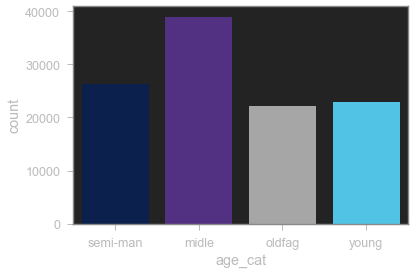

In [167]:
sns.countplot(df['age_cat'],palette=colors)
df['age_cat'].value_counts()

Well, we can see that our dataset has more people with middle age. However, there is nothing strange

<a id="sec8.3"></a>
## [Numerical to category](#sec8.3)

Sort **decline_app_cnt** by groups:
1. 0

2. 1

3. 2

4. More or equal 4

In [168]:
df['decline_cat'] = df['decline_app_cnt'].apply(lambda x: 4 if x >= 4 else x)
# df['bki_request_cat'] = df['bki_request_cnt'].apply(lambda x: 4 if x >= 4 else x) # option 1

In [169]:
# OPTION TWO. Create a cluster 
X = df[['bki_request_cnt','income','age']].values  # попробовать разные сочетания
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [170]:
from sklearn.cluster import KMeans
clusterNum = 7 # old val 7
k_means = KMeans(init='k-means++',n_clusters=clusterNum,n_init=15)
k_means.fit(X)
labels = k_means.labels_

In [171]:
df['clus_bki_req'] = labels

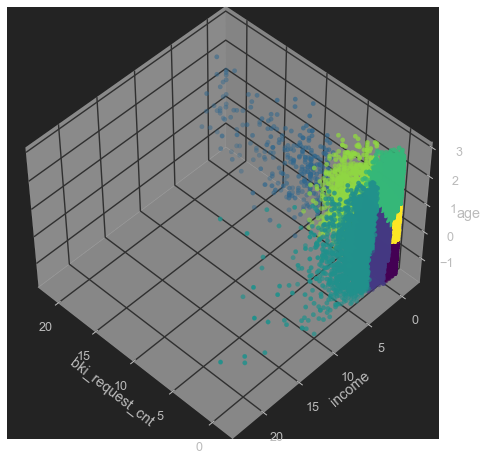

In [172]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1,figsize=(8,6))
plt.clf()
ax = Axes3D(fig,rect=[0,0,.95,1], elev = 48, azim=134)

ax.set_xlabel('bki_request_cnt')
ax.set_ylabel('income')
ax.set_zlabel('age')

ax.scatter(X[:, 1], X[:, 0], X[:, 2],c=labels.astype(np.float))
plt.show()

As we can see, we created 3 clusters depends on age, income and bki_request 

<a id="sec8.3"></a>
## [Home and work address](#sec8.3)

In [ ]:
# Option 1. Drop one of them.
#df = df.drop('work_address',axis=1)

In [173]:
#Option 2. Use PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
data = df[['work_address','home_address']].values
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data)
pca = PCA(n_components=1)
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
df['pca_address'] = pca_data

<a id="sec8.4"></a>
## [Date_time Features](#sec8.4)

In [174]:
df['app_date'] = pd.to_datetime(
    df['app_date'])  # Преобразуем в datetime

df['days_beetwen'] = df['app_date'].apply(
    lambda x: (get_days_beetwen(x)
               ))  # Кол- во дней между подачей заявки и сегодняшним числом
df['month'] = df['app_date'].apply(lambda x: (month(x)))

<a id="sec8.5"></a>
## [Guarantors](#sec8.5)

In [176]:
# with a reference to EDA add new feature - has no guarantors
def has_no_garant(edu, grnt):
    if edu == 'PGR' or edu == 'ACD':
        grnt = 1
        return grnt
    else:
        grnt = 0
        return grnt


df['has_no_guarantor'] = 0
df['has_no_guarantor'] = df[['education', 'has_no_guarantor']].apply(
    lambda x: has_no_garant(*x), axis=1)

In [96]:
df.sample(3)

,app_date,education,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,sample,default,car_comb,age_cat,decline_cat,clus_bki_req,pca_address,days_beetwen,month,has_no_guarantor
12982,2014-04-10,GRD,M,39,0,1,-2.601857,11,60,1,...,0,NaN,2,midle,0,3,-1.282573,2558,4,0
43737,2014-04-04,SCH,F,54,0,0,-1.876341,4,50,2,...,1,0.0,0,oldfag,0,1,1.086059,2564,4,0
10379,2014-03-05,GRD,F,30,0,0,-1.989516,8,50,1,...,0,NaN,0,semi-man,0,3,-2.310872,2594,3,0


<a id="sec8.7"></a>
## [ENCODING](#sec8.7)

In [177]:
encoder = Preprocessing(df)

In [178]:
# label Encoder
for i in list(['sex','foreign_passport','good_work']): #has nogarantore
    encoder.label_encoder(i)

In [179]:
cols_to_hot = ['education','region_rating',
               'sna','first_time','car_comb',
               'age_cat','decline_cat','clus_bki_req',
              'month'] # month
for col in cols_to_hot:
    df = encoder.hot_enc(col)

<a id="sec8.7"></a>
## [Dropping Cols](#sec8.7)

In [180]:
cols_to_drop = ['decline_app_cnt', 'bki_request_cnt',
                'work_address', 'home_address','app_date','age'] # AGE
df = df.drop(cols_to_drop, axis=1)

<a id="sec8.3"></a>
## [LOG FUNC](#sec8.3)

In [181]:
df['pca_address'] = df['pca_address'] + 5
cols_to_log = ['income','days_beetwen','pca_address'] # 'pca_address' 'age'

In [182]:
for col in cols_to_log:
    df[col] = df[col].apply(lambda x: np.log(x) +1)

In [145]:
df.sample(3)

,sex,good_work,score_bki,income,foreign_passport,sample,default,pca_address,days_beetwen,has_no_guarantor,...,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4,hot_encode_5,hot_encode_6,hot_encode_1,hot_encode_2,hot_encode_3,hot_encode_4
105158,1,0,-2.042708,10.903488,0,1,0.0,-2.310872,8.862882,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
104601,0,0,-2.090187,10.998798,1,1,0.0,-2.310872,8.884577,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
33783,0,1,-1.586263,11.819778,0,0,NaN,-2.310872,8.876638,0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


<a id="sec9"></a>
# [Model](#sec9)

<a id="sec9.1"></a>
## [LOG REGRESSION (naive)](#sec9.1)

In [205]:
# Extract the part of dataframe for testing
df_train = df.query('sample == 1').drop(['sample'], axis=1)
df_valid = df.query('sample == 0').drop(['sample'], axis=1)

X = df_train.drop(['default'], axis=1)
X_val = df_valid.drop(['default'], axis=1)
y = df_train.default.values

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=RANDOM_SEED)

In [207]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
# pipe_line_lr = Pipeline(steps=[('scaling', RobustScaler()),
#                                ('Logregression',LogisticRegression())])
# model = pipe_line_lr.fit(X_train,y_train)
# # y_pred_proba = model.predict_proba(X_test)[:,1]
# y_pred = model.predict(X_test)
# print(classification_report(y_test,y_pred))
# cf_matrix = confusion_matrix(y_test,y_pred)

In [208]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = lr.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred)

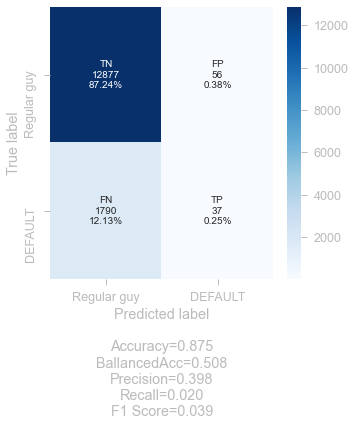

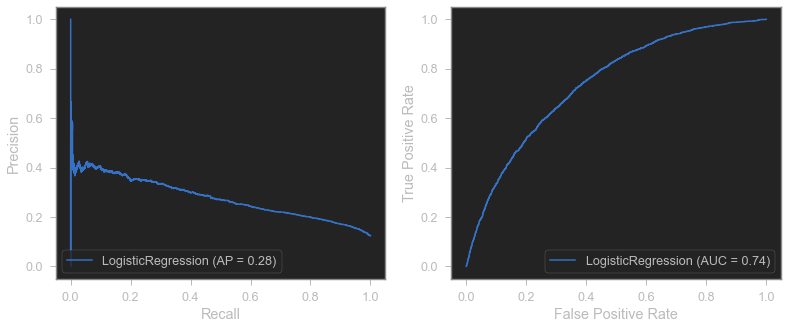

              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     12933
         1.0       0.40      0.02      0.04      1827

    accuracy                           0.87     14760
   macro avg       0.64      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



In [209]:
categories = ['Regular guy', 'DEFAULT']
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(lr,X_test,y_test)
print(classification_report(y_test,y_pred))

As ROC-AUC is not good to apply when classed disballanced, let's check precision-Recall


PR-REC AUC is very low (0.28),f1_score also extreamely low(0.01) which means that the algorithm is not yet able to distinguish between classes in any way, most of all it assigns class 0 (Not Default) to objects, we will try to choose the best parameters, and also we will make a stratification, which is often used when class disbalanced

Let's create a table with our results for further comparisons

In [210]:
df_report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])

df_report['ROC-AUC'] = roc_auc_score(y_test, y_pred_proba)
df_report['PR-AUC'] = precision_score(y_test,y_pred)
df_report['F1'] = f1_score(y_test, y_pred)
df_report['precision_0'] = precision_score(y_test, y_pred, pos_label=0)
df_report['recall_0'] = recall_score(y_test, y_pred, pos_label=0)
df_report['precision_1'] = precision_score(y_test, y_pred, pos_label=1)
df_report['recall_1'] = recall_score(y_test, y_pred, pos_label=1)

df_report.index = ['LogisticRegression']

In [211]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.99567,0.397849,0.020252


<a id="sec9.3"></a>
## [LOG REGRESSION with gridsearch & strat](#sec9.2)

In [ ]:
# pipeline = 
# lr_skf = LogisticRegression(class_weight='balanced')
# skf = StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_SEED)

# param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# # refit - пол умолчаю, то есть при предикте уже используем лучшую модель
# clf_lr = GridSearchCV(
#     lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
# clf_lr.fit(X_train, y_train)
# #cf_matrix = confusion_matrix(y_test,y_pred)

# print('Best roc_auc: {:.4}, with best C: {}'.format(
#     clf_lr.best_score_, clf_lr.best_params_))

In [ ]:
# # to_scal = ['age', 'income', 'days_beetwen','pca_address','income']
# to_scal = ['age', 'income', 'days_beetwen','pca_address']

# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train.values)
# X_test = scaler.transform(X_test.values)

In [224]:
lr_skf = LogisticRegression(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=10, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# refit - пол умолчаю, то есть при предикте уже используем лучшую модель
clf_lr = GridSearchCV(
    lr_skf, param, scoring='roc_auc', refit=True, cv=skf)
clf_lr.fit(X_train, y_train)
y_pred_skf = clf_lr.predict(X_test)
cf_matrix = confusion_matrix(y_test,y_pred_skf)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lr.best_score_, clf_lr.best_params_))

Best roc_auc: 0.6675, with best C: {'C': 3.334, 'penalty': 'l2'}


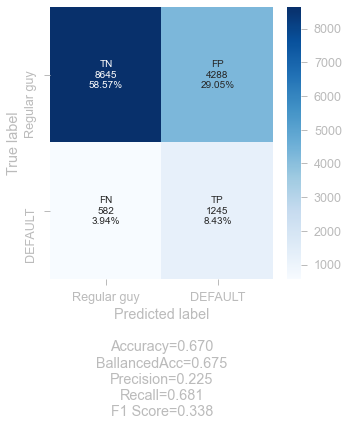

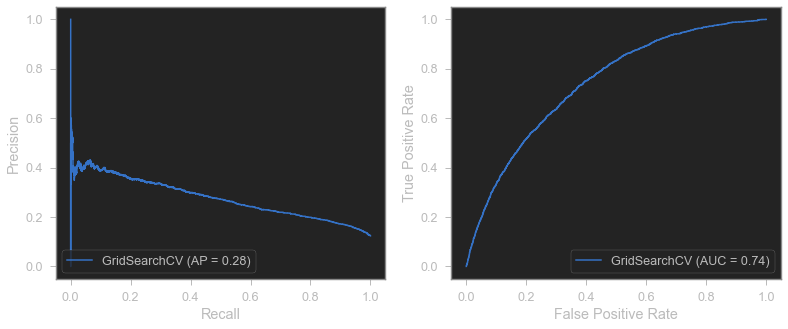

In [225]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)
make_roc_auc(clf_lr,X_test,y_test)

In [240]:
# Функция для возвращения таблицы с метриками
def get_scores(report_df, model, X_test, y_test, name):

    report = pd.DataFrame(columns={'ROC-AUC'}, data=[0])
    report['ROC-AUC'] = roc_auc_score(y_test,
                                      model.predict_proba(X_test)[:, 1])
    report['PR-AUC'] = precision_score(y_test,model.predict(X_test))
    report['F1'] = f1_score(y_test, model.predict(X_test))
    report['precision_0'] = precision_score(
        y_test, model.predict(X_test), pos_label=0)
    report['precision_1'] = precision_score(
        y_test, model.predict(X_test), pos_label=1)
    report['recall_0'] = recall_score(
        y_test, model.predict(X_test), pos_label=0)
    report['recall_1'] = recall_score(
        y_test, model.predict(X_test), pos_label=1)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [226]:
df_report = get_scores(df_report, clf_lr, X_test,
                       y_test, 'LogisticRegression_skf')

In [227]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.995670,0.397849,0.020252
LogisticRegression_skf,0.740617,NaN,0.338269,0.936917,0.668368,0.224973,0.681445
LogisticRegression_skf_imb,0.740143,NaN,0.338353,0.937066,0.667749,0.224928,0.682540
RandomForestClassifier,0.701189,NaN,0.042421,0.878122,0.994974,0.386792,0.022441
LogisticRegression_skf,0.740624,NaN,0.338315,0.936924,0.668445,0.225014,0.681445


The completeness has noticeably grown in connection with this f1, but there is no particular difference in balancing classes, taking into account the search for the best parameters and a stratified sample for training.

Let's try to add objects of the missing class

In [217]:
oversample = RandomOverSampler(sampling_strategy=1.0)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [218]:
lr_skf = LogisticRegression()
skf = StratifiedShuffleSplit(n_splits=10, random_state=RANDOM_SEED)

param = {'C': np.linspace(0.001, 10, 10), 'penalty': ['l1', 'l2']}

# verbose - печать резльутата выполнения обучения, чем больше  значение (по умол 0), тем больше информации
clf_lr_over = GridSearchCV(lr_skf, param, scoring='roc_auc', cv=skf, verbose=1)
clf_lr_over.fit(X_over, y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_lr_over.best_score_, clf_lr_over.best_params_))

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   47.7s finished


Best roc_auc: 0.7301, with best C: {'C': 5.556, 'penalty': 'l2'}


In [219]:
df_report = get_scores(df_report, clf_lr_over, X_test,
                       y_test, 'LogisticRegression_skf_imb')

In [220]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.995670,0.397849,0.020252
LogisticRegression_skf,0.740617,NaN,0.338269,0.936917,0.668368,0.224973,0.681445
LogisticRegression_skf_imb,0.740143,NaN,0.338353,0.937066,0.667749,0.224928,0.682540


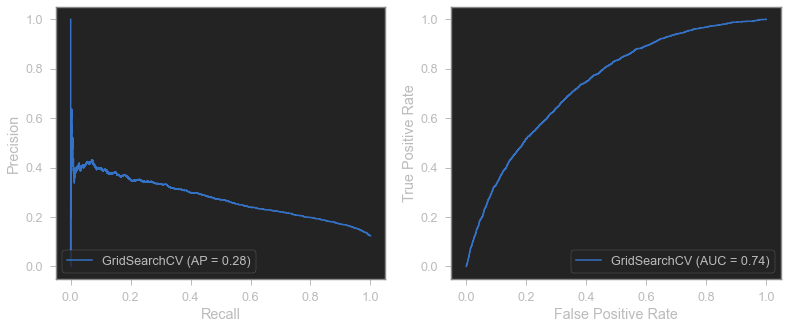

In [221]:
make_roc_auc(clf_lr_over,X_test,y_test)

Well, oversampling did not give us significant increase of metrics

<a id="sec9.4"></a>
## [Random Forest](#sec9.4)

In [222]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

df_report = get_scores(df_report, rf, X_test, y_test, 'RandomForestClassifier')

In [223]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.995670,0.397849,0.020252
LogisticRegression_skf,0.740617,NaN,0.338269,0.936917,0.668368,0.224973,0.681445
LogisticRegression_skf_imb,0.740143,NaN,0.338353,0.937066,0.667749,0.224928,0.682540
RandomForestClassifier,0.701189,NaN,0.042421,0.878122,0.994974,0.386792,0.022441


In [228]:
# Grid Search
rf_skf = RandomForestClassifier(class_weight='balanced')
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 30],
         'n_estimators': [600, 1000]}

clf_rf = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf.fit(X_train, y_train)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_rf.best_score_, clf_rf.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   56.9s remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.5min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.5min remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished


Best roc_auc: 0.7279, with best C: {'bootstrap': True, 'max_depth': 10, 'n_estimators': 1000}


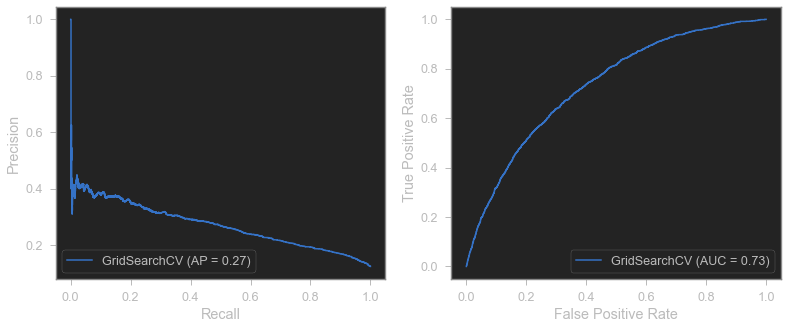

In [229]:
df_report = get_scores(df_report, clf_rf, X_test, y_test, 'RandomForestClassifier_skf')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_rf, X_test, y_test, ax=ax1)
plot_roc_curve(clf_rf, X_test, y_test, ax=ax2);

In [230]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.995670,0.397849,0.020252
LogisticRegression_skf,0.740617,NaN,0.338269,0.936917,0.668368,0.224973,0.681445
LogisticRegression_skf_imb,0.740143,NaN,0.338353,0.937066,0.667749,0.224928,0.682540
RandomForestClassifier,0.701189,NaN,0.042421,0.878122,0.994974,0.386792,0.022441
LogisticRegression_skf,0.740624,NaN,0.338315,0.936924,0.668445,0.225014,0.681445
RandomForestClassifier_skf,0.733029,NaN,0.341463,0.927878,0.731153,0.239002,0.597701


In [232]:
y_pred_clf_rf = clf_rf.predict(X_test)
cf_matrix =confusion_matrix(y_test,y_pred_clf_rf)

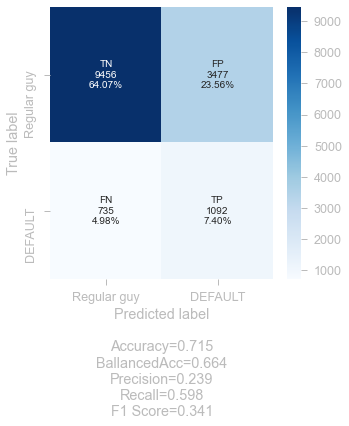

In [233]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)

In [234]:
# Grid Search
rf_skf = RandomForestClassifier()
skf = StratifiedShuffleSplit(n_splits=5, random_state=10)

param = {'bootstrap': [True],
         'max_depth': [10, 30],
         'n_estimators': [200, 600]}

clf_rf_over = GridSearchCV(
    rf_skf, param, scoring='roc_auc', refit=True, cv=skf, verbose=3, n_jobs=-1)
clf_rf_over.fit(X_over, y_over)

print('Best roc_auc: {:.4}, with best C: {}'.format(
    clf_rf_over.best_score_, clf_rf_over.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:   46.0s remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  2.6min remaining:   17.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished


Best roc_auc: 0.9998, with best C: {'bootstrap': True, 'max_depth': 30, 'n_estimators': 200}


In [236]:
y_pred_clf_rf_over = clf_rf_over.predict(X_test)
cf_matrix =confusion_matrix(y_test,y_pred_clf_rf_over)

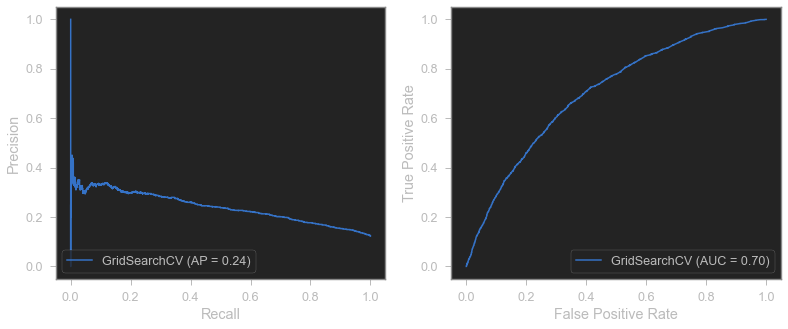

In [241]:
df_report = get_scores(df_report, clf_rf_over, X_test, y_test,
                       'RandomForestClassifier_skf_imb')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

plot_precision_recall_curve(clf_rf_over, X_test, y_test, ax=ax1)
plot_roc_curve(clf_rf_over, X_test, y_test, ax=ax2);

In [242]:
df_report

,ROC-AUC,PR-AUC,F1,precision_0,recall_0,precision_1,recall_1
LogisticRegression,0.740887,0.397849,0.038542,0.877957,0.995670,0.397849,0.020252
LogisticRegression_skf,0.740617,NaN,0.338269,0.936917,0.668368,0.224973,0.681445
LogisticRegression_skf_imb,0.740143,NaN,0.338353,0.937066,0.667749,0.224928,0.682540
RandomForestClassifier,0.701189,NaN,0.042421,0.878122,0.994974,0.386792,0.022441
LogisticRegression_skf,0.740624,NaN,0.338315,0.936924,0.668445,0.225014,0.681445
RandomForestClassifier_skf,0.733029,NaN,0.341463,0.927878,0.731153,0.239002,0.597701
RandomForestClassifier_skf_imb,0.704690,NaN,0.134374,0.882913,0.974870,0.322917,0.084839
RandomForestClassifier_skf_imb,0.704690,0.322917,0.134374,0.882913,0.974870,0.322917,0.084839


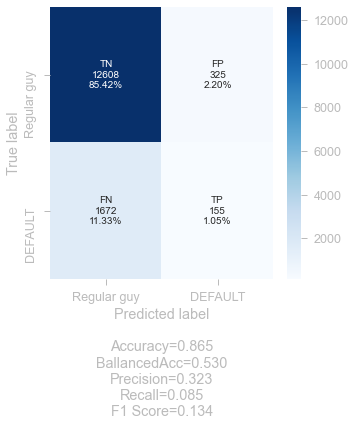

In [239]:
make_confusion_matrix(cf_matrix,categories=categories,sum_stats=True)

Chek missing data

In [ ]:
df.isnull().sum()

Let's fix missing data

In [ ]:
df['education'] = df['education'].fillna(
    df['education'].value_counts().index[0])

Create lists with depicted types of data

In [ ]:
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
cat_cols = ['education','home_address','work_address']
num_cols = ['age','decline_app_cnt','income','bki_request_cnt']

Check the distrinution of numeric columns

In [ ]:
for i in num_cols:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

BLA BLA

In [ ]:
df1 = df.copy()
for col in num_cols:
    df1[col] = df[col].apply(lambda x: np.log(x+1))

In [ ]:
for i in num_cols:
    plt.figure(figsize=(20, 3))
    plt.subplot(121)
    sns.distplot(df1[i].values, bins=20, color=colors[1])
    plt.title('variable distribution\n' + i, fontsize=15)
    plt.xlabel(i)
    plt.ylabel('Quantity (frequency)')

    plt.subplot(122)
    sns.boxplot(x = 'default',y = i,data=df1)
    plt.title('variable distribution\n' + i, fontsize=15)
    plt.xlabel(i)

<a id="sec5.1"></a>
## [Correclation](#sec5.1)

In [ ]:
sns.heatmap(df[num_cols].corr().abs(),vmin=0,vmax=1,annot=True,square=True)

<a id="sec5.2"></a>
## [Significance of continuous variables ](#sec5.2)

В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 

В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели

In [ ]:
from sklearn.feature_selection import f_classif

In [ ]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

<a id="sec6"></a>
# [Categorical Vars](#sec6)

Самый простой способ — отобразить каждое значение категории в уникальное число. Например, в поле sex значение sex = female преобразовать в , а sex = male — в . Эту простую операцию приходится делать достаточно часто, поэтому в модуле sklearn.preprocessing именно для этой задачи реализован класс LabelEncoder.

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

Сработало! Теперь всегда можно обратиться к classes_ , если забыли, что закодировали. Применим LabelEncoder ко всему набору бинарных переменных.

In [ ]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
df2 = df.copy()

In [ ]:
for column in cat_cols:
    df2[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df2.head()

In [ ]:
imp_cat = pd.Series(mutual_info_classif(df2[bin_cols + cat_cols], df2['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных к машинному обучению

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [ ]:
X_cat.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(df[num_cols].values)

In [ ]:
# Объединяем

X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score

In [ ]:
probs = classifier.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
f1 = f1_score(y_test,y_pred)
print(f1)

In [ ]:
y_pred.sum()

In [ ]:
y_test.sum()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=100000)
model.fit(X_train,y_train)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
f1 = f1_score(y_test,y_pred)
print(f1)

In [ ]:
probs = classifier.predict_proba(X_test)
probs = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()